In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys

plt.style.use('seaborn')
%matplotlib inline

# Load snapshot data
# df = pd.read_csv(r'Snapshot CSVs/All_Snapshots.csv')

In [103]:
up_df = pd.read_csv(r'Snapshot CSVs/Up_Snapshot.csv')
peak_df = pd.read_csv(r'Snapshot CSVs/Peak_Snapshot.csv')
rim_df = pd.read_csv(r'Snapshot CSVs/Rim_Snapshot.csv')
fall_df = pd.read_csv(r'Snapshot CSVs/Fall_Snapshot.csv')

def dropAllDuplicates(df):
    duplicates = df.drop(['EVENT_NUM', 'SHOOTER_ID', 'SHOT_DISTANCE', 'SHOT_TIME',
                          'OFFENSIVE_REB', 'EVENT_TIME'], axis=1).duplicated(keep=False)
    return df[~duplicates]

up_df = dropAllDuplicates(up_df)
peak_df = dropAllDuplicates(peak_df)
rim_df = dropAllDuplicates(rim_df)
fall_df = dropAllDuplicates(fall_df)

In [104]:
def flipCourt(df):
    xlocs = [col for col in df.columns if 'XLOC' in col]
    ylocs = [col for col in df.columns if 'YLOC' in col]
    
    for i in range(0, len(xlocs)):
        df[xlocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df[xlocs[i]],
                                df[xlocs[i]])
        df[ylocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df[ylocs[i]],
                                df[ylocs[i]])
    return df

up_df = flipCourt(up_df)
peak_df = flipCourt(peak_df)
rim_df = flipCourt(rim_df)
fall_df = flipCourt(fall_df)

In [105]:
# Remove non-shots. These are plays that descend to 11 feet farther than 5 feet away
goodrows = ((rim_df['BALL_DIST_RIM1'] < 5) | (rim_df['BALL_DIST_RIM2'] < 5))

up_df = up_df[goodrows]
peak_df = peak_df[goodrows]
rim_df = rim_df[goodrows]
fall_df = fall_df[goodrows]

# Shots outside of 30 feet
badrows = (up_df['BALL_XLOC'] > 35.25)

up_df = up_df[~badrows]
peak_df = peak_df[~badrows]
rim_df = rim_df[~badrows]
fall_df = fall_df[~badrows]

In [2]:
def playerDistToBall(px, py, bx, by):
    return ((px - bx)**2 + (py - by)**2)**.5

def closerRim(row):
    if row['BALL_DIST_RIM1_FALL'] < row['BALL_DIST_RIM2_FALL']:
        return '1'
    else:
        return '2'
    
df['rim'] = df.apply(closerRim, axis=1)

In [13]:
def newOrigin(x, y, ox, oy):
    x = x - ox
    y = y - oy
    return (x,y)

def rotateXY(x, y, theta):
    xnew = x*np.cos(theta) + y*np.sin(theta)
    ynew = -x*np.sin(theta) + y*np.cos(theta)
    return (xnew, ynew)

def boxedOut(player, team, row, suf, origin):
    if origin == 'ball':
        ox = row['BALL_XLOC'+suf]
        oy = row['BALL_YLOC'+suf]
        
    elif origin == 'rim':
        oy = 25
        if row['rim'] == '1':
            ox = 5.25
        elif row['rim'] == '2':
            ox = 88.75
        
    p = [row[player[0]], row[player[1]]]
    p[0], p[1] = newOrigin(p[0], p[1], ox = ox, oy = oy)
    
    theta = np.arctan2(p[1], p[0])
    p[0], p[1] = rotateXY(p[0], p[1], theta)
    
    p2 = [None, None]
    for t in team:
        p2[0], p2[1] = newOrigin(row[t[0]], row[t[1]], ox = ox, oy = oy)
        p2[0], p2[1] = rotateXY(p2[0], p2[1], theta)
        if (((0 < (p[0] - p2[0]) < np.fabs(p[0])) or
            (0 < (p2[0] - p[0]) < np.fabs(p[0]))) and
            (np.fabs(p2[0]/2) > np.fabs(p2[1])) and
            (np.fabs(p2[1]) < 2)):
            return (1, p2[0], p2[1], t[0][:8])
    return (0, 0, 0, '')
    

def determineAllBoxOuts(row, suf, origin = 'rim'):
    players = [['PLAYER1_XLOC'+suf, 'PLAYER1_YLOC'+suf],
               ['PLAYER2_XLOC'+suf, 'PLAYER2_YLOC'+suf],
               ['PLAYER3_XLOC'+suf, 'PLAYER3_YLOC'+suf],
               ['PLAYER4_XLOC'+suf, 'PLAYER4_YLOC'+suf],
               ['PLAYER5_XLOC'+suf, 'PLAYER5_YLOC'+suf],
               ['PLAYER6_XLOC'+suf, 'PLAYER6_YLOC'+suf],
               ['PLAYER7_XLOC'+suf, 'PLAYER7_YLOC'+suf],
               ['PLAYER8_XLOC'+suf, 'PLAYER8_YLOC'+suf],
               ['PLAYER9_XLOC'+suf, 'PLAYER9_YLOC'+suf],
               ['PLAYER10_XLOC'+suf, 'PLAYER10_YLOC'+suf]
               ]
    for i in range(0,10):
        team = list(players)
        player = team.pop(i)
        row['BOXED_OUT'+str(i+1)+suf], row['BOXED_OUT'+str(i+1)+'x'+suf], row['BOXED_OUT'+str(i+1)+'y'+suf], row['BOXED_OUT'+str(i+1)+'BY'+suf] = boxedOut(player, team, row, suf, origin=origin)
        
    return row

suf = '_FALL'
origin = 'ball'
needed_cols = ['PLAYER1_XLOC'+suf, 'PLAYER1_YLOC'+suf,
               'PLAYER2_XLOC'+suf, 'PLAYER2_YLOC'+suf,
               'PLAYER3_XLOC'+suf, 'PLAYER3_YLOC'+suf,
               'PLAYER4_XLOC'+suf, 'PLAYER4_YLOC'+suf,
               'PLAYER5_XLOC'+suf, 'PLAYER5_YLOC'+suf,
               'PLAYER6_XLOC'+suf, 'PLAYER6_YLOC'+suf,
               'PLAYER7_XLOC'+suf, 'PLAYER7_YLOC'+suf,
               'PLAYER8_XLOC'+suf, 'PLAYER8_YLOC'+suf,
               'PLAYER9_XLOC'+suf, 'PLAYER9_YLOC'+suf,
               'PLAYER10_XLOC'+suf, 'PLAYER10_YLOC'+suf,
               'BALL_XLOC'+suf, 'BALL_YLOC'+suf,
               'rim',
               'PLAYER1_ID'+suf, 'PLAYER2_ID'+suf, 'PLAYER3_ID'+suf,
               'PLAYER4_ID'+suf, 'PLAYER5_ID'+suf, 'PLAYER6_ID'+suf,
               'PLAYER7_ID'+suf, 'PLAYER8_ID'+suf, 'PLAYER9_ID'+suf,
               'PLAYER10_ID'+suf, 'REBOUNDER_ID'+suf
              ]
df2 = df[needed_cols].copy()
df2 = df2.apply(lambda x: determineAllBoxOuts(x, '_FALL', origin='ball'), axis=1)

In [4]:
teamlist = list(df['PLAYER1_TEAMID_FALL'].unique())
df = df[~df['REBOUNDER_ID_FALL'].isin(teamlist)]

In [10]:
x1, y1 = newOrigin(df.iloc[16]['PLAYER4_XLOC_FALL'],
                   df.iloc[16]['PLAYER4_YLOC_FALL'],
                   df.iloc[16]['BALL_XLOC_FALL'],
                   df.iloc[16]['BALL_YLOC_FALL'])

x9, y9 = newOrigin(df.iloc[16]['PLAYER10_XLOC_FALL'],
                   df.iloc[16]['PLAYER10_YLOC_FALL'],
                   df.iloc[16]['BALL_XLOC_FALL'],
                   df.iloc[16]['BALL_YLOC_FALL'])

theta = np.arctan2(y1, x1)
x1, y1 = rotateXY(x1, y1, theta)

x9, y9 = rotateXY(x9, y9, theta)
print('{}, {}'.format(x1, y1))

print('{}, {}'.format(x9, y9))

25.834350864507893, -3.552713678800501e-15
10.16943113935309, 0.12224807137845928


Rebounder: PLAYER7_
BOXED_OUT1_FALL             1
BOXED_OUT1x_FALL       1.4219
BOXED_OUT1y_FALL    -0.906967
BOXED_OUT0BY_FALL     PLAYER7
BOXED_OUT2_FALL             1
BOXED_OUT2x_FALL      1.42014
BOXED_OUT2y_FALL     0.909715
BOXED_OUT1BY_FALL     PLAYER7
BOXED_OUT3_FALL             1
BOXED_OUT3x_FALL      5.86715
BOXED_OUT3y_FALL     0.510998
BOXED_OUT2BY_FALL     PLAYER2
BOXED_OUT4_FALL             1
BOXED_OUT4x_FALL     0.689988
BOXED_OUT4y_FALL       1.2953
BOXED_OUT3BY_FALL     PLAYER8
BOXED_OUT5_FALL             1
BOXED_OUT5x_FALL     0.175073
BOXED_OUT5y_FALL      1.67742
BOXED_OUT4BY_FALL     PLAYER7
BOXED_OUT6_FALL             1
BOXED_OUT6x_FALL     0.171087
BOXED_OUT6y_FALL       1.4576
BOXED_OUT5BY_FALL     PLAYER8
BOXED_OUT7_FALL             1
BOXED_OUT7x_FALL      2.56213
BOXED_OUT7y_FALL      1.63427
BOXED_OUT6BY_FALL     PLAYER1
BOXED_OUT8_FALL             1
BOXED_OUT8x_FALL      1.13272
BOXED_OUT8y_FALL      1.24953
BOXED_OUT7BY_FALL     PLAYER7
BOXED_OUT9_FALL     

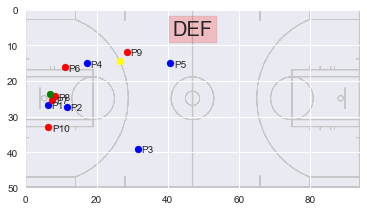

In [11]:
def plotPlay(df, i, suf):
    court = plt.imread("fullcourt.png")
    plt.imshow(court, zorder = 0, extent=[0,94,50,0])
    col = 'PLAYER{}_{}LOC{}'
    row = df.iloc[i]
    
    for j in range(1,11):
        x = col.format(j, 'X', suf)
        y = col.format(j, 'Y', suf)
        if j <= 5:
            c = 'blue'
        else:
            c = 'red'
        plt.scatter(row[x], row[y], c = c)
        plt.text(row[x]+1, row[y]+1, 'P'+str(j))

    plt.scatter(row['BALL_XLOC_UP'], row['BALL_YLOC_UP'], c = 'yellow')
    plt.scatter(row['BALL_XLOC_FALL'], row['BALL_YLOC_FALL'], c = 'green')
    
#     plt.text(row['PLAYER1_XLOC'+suf], row['PLAYER1_YLOC'+suf], 'P1')
    
    if row['OFFENSIVE_REB_FALL'] == 1:
        txt = 'OFF'
        col = 'blue'
    else:
        txt = 'DEF'
        col = 'red'
    plt.text(47, 7, txt, fontsize=20, horizontalalignment='center',
             bbox=dict(facecolor=col, alpha=0.2))
    
n = 17

id_cols = [col for col in df.columns if '_ID_FALL' in col]
b = (df.iloc[n][id_cols] == df.iloc[n]['REBOUNDER_ID_FALL'])
print('Rebounder: {}'.format(b[b==True].index[0][:-7]))

box_cols = [col for col in df.columns if 'BOXED_OUT' in col]
print(df.iloc[n][box_cols])

plotPlay(df, n, '_FALL')

In [130]:
def playerPosDF(row, suf, t_or_p = 't'):
    outcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5',
               'Off_PosX1', 'Off_PosX2', 'Off_PosX3', 'Off_PosX4', 'Off_PosX5',
               'Off_PosY1', 'Off_PosY2', 'Off_PosY3', 'Off_PosY4', 'Off_PosY5',
               'Off_VelX1', 'Off_VelX2', 'Off_VelX3', 'Off_VelX4', 'Off_VelX5',
               'Off_VelY1', 'Off_VelY2', 'Off_VelY3', 'Off_VelY4', 'Off_VelY5',
               'Def_PosX1', 'Def_PosX2', 'Def_PosX3', 'Def_PosX4', 'Def_PosX5',
               'Def_PosY1', 'Def_PosY2', 'Def_PosY3', 'Def_PosY4', 'Def_PosY5',
               'Def_VelX1', 'Def_VelX2', 'Def_VelX3', 'Def_VelX4', 'Def_VelX5',
               'Def_VelY1', 'Def_VelY2', 'Def_VelY3', 'Def_VelY4', 'Def_VelY5', 
               'BALL_DIST']
        
    off_dist_cols = [x for x in outcols if x[:-1] == 'Off_Dist']
    def_dist_cols = [x for x in outcols if x[:-1] == 'Def_Dist']
        
    off_posx_cols = [x for x in outcols if x[:8] == 'Off_PosX']
    def_posx_cols = [x for x in outcols if x[:8] == 'Def_PosX']
    
    off_posy_cols = [x for x in outcols if x[:8] == 'Off_PosY']
    def_posy_cols = [x for x in outcols if x[:8] == 'Def_PosY']
    
    off_velx_cols = [x for x in outcols if x[:8] == 'Off_VelX']
    def_velx_cols = [x for x in outcols if x[:8] == 'Def_VelX']
    
    off_vely_cols = [x for x in outcols if x[:8] == 'Off_VelY']
    def_vely_cols = [x for x in outcols if x[:8] == 'Def_VelY']
    
    rim = row['rim']
    if rim == '1':
        offsetx = 0
        offsety = 0
        flip = 1
    else:
        offsetx = 94
        offsety = 50
        flip = -1
    
    if t_or_p == 't':
        row['OReb'] = row['OFFENSIVE_REB' + suf]
    elif t_or_p == 'p':
        row['Rebounder_ID'] = str(int(row['REBOUNDER_ID' + suf]))
    
    for i in range(0,5):
        row[off_dist_cols[i]] = row['PLAYER'+str(i+1)+'_DIST_'+rim+suf]
        row[def_dist_cols[i]] = row['PLAYER'+str(i+6)+'_DIST_'+rim+suf]
        
        row[off_posx_cols[i]] = np.fabs(row['PLAYER'+str(i+1)+'_XLOC'+suf]-offsetx)
        row[def_posx_cols[i]] = np.fabs(row['PLAYER'+str(i+6)+'_XLOC'+suf]-offsetx)
        
        row[off_posy_cols[i]] = np.fabs(row['PLAYER'+str(i+1)+'_YLOC'+suf]-offsety)
        row[def_posy_cols[i]] = np.fabs(row['PLAYER'+str(i+6)+'_YLOC'+suf]-offsety)
        
        row[off_velx_cols[i]] = row['PLAYER'+str(i+1)+'_XVEL'+suf] * flip
        row[def_velx_cols[i]] = row['PLAYER'+str(i+6)+'_XVEL'+suf] * flip
        
        row[off_vely_cols[i]] = row['PLAYER'+str(i+1)+'_YVEL'+suf] * flip
        row[def_vely_cols[i]] = row['PLAYER'+str(i+6)+'_YVEL'+suf] * flip
        
        
    row['BALL_DIST'] = row['BALL_DIST_RIM'+rim+suf]
    
    return row
    

def buildFallDF(df, suf = '_FALL', t_or_p = 't'):
    outcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5'
              ]
        
    off_cols = [x for x in outcols if x[:-1] == 'Off_Dist']
    def_cols = [x for x in outcols if x[:-1] == 'Def_Dist']
    
    outdf = pd.DataFrame(columns = outcols)
    
    if t_or_p == 't':
        outdf['OReb'] = df['OFFENSIVE_REB' + suf]
    elif t_or_p == 'p':
        outdf['Rebounder_ID'] = df['REBOUNDER_ID' + suf].astype(int).astype(str)
        
        outdf['PLAYER_IDS'] = ''
        for i in range(1,11):
            outdf['PLAYER_IDS'] = outdf['PLAYER_IDS'] + \
                                    df['PLAYER'+str(i)+'_ID'+suf].astype(int).astype(str) + ' '
    
    for i in range(0,5):
        outdf[off_cols[i]] = playerDistToBall(df['PLAYER'+str(i+1)+'_XLOC'+suf],
                                                     df['PLAYER'+str(i+1)+'_YLOC'+suf],
                                                     df['BALL_XLOC'+suf],
                                                     df['BALL_YLOC'+suf])
        outdf[def_cols[i]] = playerDistToBall(df['PLAYER'+str(i+6)+'_XLOC'+suf],
                                                     df['PLAYER'+str(i+6)+'_YLOC'+suf],
                                                     df['BALL_XLOC'+suf],
                                                     df['BALL_YLOC'+suf])

    
#     ovals = outdf[off_cols].values
#     dvals = outdf[def_cols].values
#     ovals.sort(axis=1)
#     dvals.sort(axis=1)
#     outdf[off_cols] = ovals
#     outdf[def_cols] = dvals
    
    return outdf

In [ ]:
outcols = ['Off_PosX1', 'Off_PosX2', 'Off_PosX3', 'Off_PosX4', 'Off_PosX5',
           'Off_PosY1', 'Off_PosY2', 'Off_PosY3', 'Off_PosY4', 'Off_PosY5',
           'Off_VelX1', 'Off_VelX2', 'Off_VelX3', 'Off_VelX4', 'Off_VelX5',
           'Off_VelY1', 'Off_VelY2', 'Off_VelY3', 'Off_VelY4', 'Off_VelY5',
           'Def_PosX1', 'Def_PosX2', 'Def_PosX3', 'Def_PosX4', 'Def_PosX5',
           'Def_PosY1', 'Def_PosY2', 'Def_PosY3', 'Def_PosY4', 'Def_PosY5',
           'Def_VelX1', 'Def_VelX2', 'Def_VelX3', 'Def_VelX4', 'Def_VelX5',
           'Def_VelY1', 'Def_VelY2', 'Def_VelY3', 'Def_VelY4', 'Def_VelY5', 
           'BALL_DIST', 'Rebounder_ID']

outdf = buildFallDF(df, t_or_p = 'p')
teamlist = df['PLAYER1_TEAMID_UP'].unique().astype(int).astype(str)
outdf = outdf[~outdf['Rebounder_ID'].isin(teamlist)]
# df = df.apply(lambda x: playerPosDF(x, '_UP', 'p'), axis = 1)
# updf = df[outcols].copy()

In [131]:
def orderRows(row):
    sortcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5'
               ]
    id_to_idx = dict(zip(row['PLAYER_IDS'].split(), row.index))

    return row[sortcols].sort_values().index.get_loc(id_to_idx[row['Rebounder_ID']])
    
outdf['Player_Num'] = outdf.apply(orderRows, axis = 1)

def sortByClosest(df):
    in_cols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5'
               ]
    
    vals = df[in_cols].values
    vals.sort(axis=1)
    df[in_cols] = vals
    

outdf.drop(['PLAYER_IDS', 'Rebounder_ID'], axis = 1, inplace = True)
sortByClosest(outdf)

In [134]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

X = outdf.drop('Player_Num', axis = 1)
y = outdf['Player_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
t0 = time.time()
# No data split
model = KNN(n_neighbors=3)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
# print(metrics.precision_score(y_test, predicted))
# print(metrics.recall_score(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))
t1 = time.time()
print (t1 - t0)

[[3140  126   41   17    9    4    2    0    0    0]
 [ 442   34   10    4    3    0    0    0    0    0]
 [ 247   23    6    4    1    1    0    0    0    0]
 [ 136   13    6    1    2    2    1    0    0    0]
 [ 103    4    6    3    2    3    0    0    0    0]
 [  82    6    3    3    3    0    1    0    0    0]
 [  49    7    3    1    1    2    2    1    0    0]
 [  30    3    1    0    1    0    1    0    0    0]
 [  20    1    0    0    0    0    1    0    0    0]
 [  17    2    1    0    0    0    0    0    0    0]]
0.22101283073425293


In [45]:
parameters = {'n_neighbors': range(1,100)}
knn = KNN()
knnmodel = GridSearchCV(knn, parameters)
knnmodel.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 100)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [4]:
# pd.DataFrame(list(zip(X.columns, [x[0] for x in np.transpose(model.coef_)])))

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))

[[4037   23]
 [ 846   13]]


In [20]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(KNN(n_neighbors=30), X, y, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.823604839602
4.147237062454224


In [39]:
from imblearn.over_sampling import RandomOverSampler

X = outdf.drop('Off_Reb', axis = 1)
y = outdf['Off_Reb']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(model2.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, predicted))

0.862980280545
[[3888  172]
 [ 502  357]]


In [32]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(GradientBoostingClassifier(n_estimators=100,
                                                    learning_rate=1.0,
                                                    max_depth=1,
                                                    random_state=0),
                         X_resampled, y_resampled, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.599900211092
8.290473937988281
